In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import re, string, unicodedata
import nltk
import contractions
import inflect

import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

import re

from wordcloud import WordCloud, STOPWORDS

import nltk
# import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer


from sklearn import metrics
from sklearn.model_selection import train_test_split
# from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
%matplotlib inline

import scipy

from gensim import corpora
from gensim import corpora
from gensim.similarities.docsim import Similarity
from gensim import corpora, models, similarities

import pickle
import time

# Read Train Split and Validation Data

In [2]:
rev_busi_Pho= pd.read_csv('../data/filtered_reviews_in_Phonex.csv', parse_dates=["date"])

train_df  = pickle.load(open('../data/train_df.pkl', "rb"))
valid_df = pickle.load(open('../data/valid_df.pkl', "rb"))
test_df = pickle.load(open('../data/test_df.pkl', "rb"))

In [3]:
train_df = train_df.merge(rev_busi_Pho[["review_id", "user_id", "business_id", "text"]], how = "left", on = ["user_id", "business_id"])
valid_df = valid_df.merge(rev_busi_Pho[["review_id", "user_id", "business_id", "text"]], how = "left", on = ["user_id", "business_id"])
test_df  = test_df.merge(rev_busi_Pho[["review_id", "user_id", "business_id", "text"]], how = "left", on = ["user_id", "business_id"])

train_df.head(1)

,user_id,business_id,stars,review_id,text
0,--2HUmLkcNHZp0xw6AMBPg,yX0pOWG_Be9TjGnm0aihVA,5.0,tfi5EOpqZw637p3AJtOUMg,Obsessed with their chicken salad and sweet fr...


In [4]:
train_df.shape
valid_df.shape
test_df.shape

(180559, 5)

(19500, 5)

(19500, 5)

In [5]:
print("unique users in training set:", train_df["user_id"].nunique())
print("unique businesses in training set:", train_df["business_id"].nunique())
print("unique users in test set:", test_df["user_id"].nunique())
print("unique businesses in test set:", test_df["business_id"].nunique())

unique users in training set: 19683
unique businesses in training set: 1728
unique users in test set: 19500
unique businesses in test set: 1672


# Content-based Model, NLP

### - Combine reviews of each business_id as its document 

In [6]:
train_df.head(1)
text_train_df = train_df.groupby(["business_id"])["text"].apply(lambda x: x.str.cat()).reset_index()
len(text_train_df)
text_train_df.head(1)

,user_id,business_id,stars,review_id,text
0,--2HUmLkcNHZp0xw6AMBPg,yX0pOWG_Be9TjGnm0aihVA,5.0,tfi5EOpqZw637p3AJtOUMg,Obsessed with their chicken salad and sweet fr...


1728

,business_id,text
0,-050d_XIor1NpCuWkbIVaQ,Great Food. Great Coffee. Great Service. Amazi...


### - Generate Wordcloud

In [7]:
# # gather all words together
# all_text = ""
# all_snippets = text_train_df["text"].values

# for snippet in all_snippets:
#     all_text += snippet

# # plot Wordcloud
# wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',width=6000,height=6000).generate(all_text)
# plt.figure(figsize = (10,10))
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

### - Text Prepocessing

In [8]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
            
    return new_words

def remove_special(words):
    """Remove special signs like &*"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[-,$()#+&*]', '', word)
        if new_word != '':
            new_words.append(new_word)
            
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
            
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""  
    stopwords = nltk.corpus.stopwords.words('english')
    myStopWords = []
    stopwords.extend(myStopWords)
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
            
    return new_words

def to_lowercase(words):
    """Convert words to lowercase"""
    new_words=[]
    for word in words:
        new_words.append(word.lower())
        
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
        
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
        
    return lemmas

def normalize_lemmatize(words):
    words = remove_special(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words = stem_words(words)
    words = lemmatize_verbs(words)
    
    return words


In [9]:
def get_processed(sample):
    processed = pd.DataFrame(data=[],columns = ['business_id', 'text'])
    new_texts = []

    for i in range(0, len(sample)):
        business_id = sample['business_id'].iloc[i]
        words = nltk.word_tokenize(sample['text'].iloc[i])
        text = ' '.join(normalize_lemmatize(words))
        dfnew = pd.DataFrame([[business_id, text]], columns=['business_id', 'text'])
        new_texts.append(text)
        processed = processed.append(dfnew,ignore_index = True)

    return processed


In [10]:
df_texts_train = get_processed(text_train_df)
df_texts_train.to_pickle('../data/text_train_df.pkl')

### - Cosine Similarity

In [11]:
def get_tfidf_matrix(processed):
    '''
    get the Tf-Idf matrix of processed
    
    '''
    TV = TfidfVectorizer(stop_words = "english")
    processed["text"] = processed["text"].fillna('')
    tfidf_matrix = TV.fit_transform((processed["text"]))
    
    return tfidf_matrix

def get_cos_sim_matrix(tfidf_matrix, n):
    '''
    use truncated SVD to reduce dimensions to n 
    @n: the left dimensions 
    '''
    SVD = TruncatedSVD(n_components = n , random_state = 42) # 42 is the ultimate answer to everything
    tfidf_truncated = SVD.fit_transform(tfidf_matrix)
    cosine_sim = cosine_similarity(tfidf_truncated, tfidf_truncated)
    
    return cosine_sim



### - Dimension Reduction

<BarContainer object of 1727 artists>

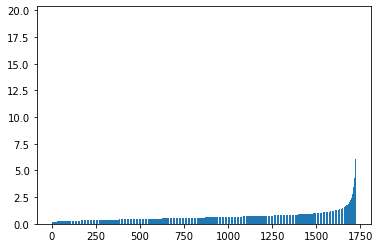

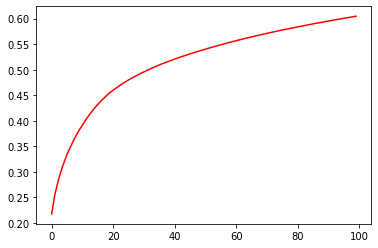

In [12]:
tfidf_matrix = get_tfidf_matrix(text_train_df)
u, s, vt  = scipy.sparse.linalg.svds(tfidf_matrix, k = tfidf_matrix.shape[0]-1)
plt.bar(range(len(s)),s)
plt.show()

plt.plot(range(len(s))[:100], np.cumsum(sorted((s**2 / sum(s**2)),reverse = True)[:100]), "r" )
plt.show()

In [13]:
tfidf_matrix = get_tfidf_matrix(text_train_df)
cosine_sim = get_cos_sim_matrix(tfidf_matrix, 20)
df_sim = pd.DataFrame(cosine_sim, index=text_train_df['business_id'], columns=text_train_df['business_id'])
df_sim.head(1)
cosine_sim.shape

business_id,-050d_XIor1NpCuWkbIVaQ,-0WegMt6Cy966qlDKhu6jA,-0tgMGl7D9B10YjSN2ujLA,-1UMR00eXtwaeh59pEiDjA,-45kMvS7h38CGaWugPY0rg,-8JaNeG3etLgOVyg2gOIiA,-9eNGMp8XiygI8t8QFuFWw,-A9sm-E6uQxWTJ_MuyOzFw,-Bdw-5H5C4AYSMGnAvmnzw,-BxWyEIQ6wypT-37MzZizQ,...,zSicVxnJHV8indit0oFuNw,zU63bs3Ofe8y1peOgOFJaA,zYZPpOqo_2YrLJLOmjlgPQ,zaBk2imYnk7rG7IdOMhRmA,zbrFk-4ejesAJD8EwcdHxg,zc1sur_MxkKkD6P8gYXQbg,zidkKI_N1OPxsiddTOQH_Q,znH36RmIAI4wcHy9WiEO5Q,zrTGcb83AsfyVTMrsCa65A,zwmps5SXn30g-f5wqg_r9A
business_id,,,,,,,,,,,,,,,,,,,,,
-050d_XIor1NpCuWkbIVaQ,1.0,0.529566,0.53278,0.949796,0.660216,0.478488,0.584917,0.262599,0.64382,0.589876,...,0.966908,0.509607,0.321309,0.210434,0.458903,0.983822,0.282168,0.494805,0.609763,0.457363


(1728, 1728)

<Figure size 432x288 with 0 Axes>

(array([4.0000e+00, 0.0000e+00, 2.0000e+00, 4.0000e+00, 1.0000e+01,
        1.0000e+01, 2.0000e+01, 5.2000e+01, 2.6200e+02, 9.8000e+02,
        1.9700e+03, 3.1640e+03, 4.4100e+03, 5.7740e+03, 7.2940e+03,
        8.8580e+03, 1.0790e+04, 1.3054e+04, 1.4396e+04, 1.6962e+04,
        1.8600e+04, 1.9764e+04, 2.1506e+04, 2.3638e+04, 2.6212e+04,
        2.9348e+04, 3.1886e+04, 3.4552e+04, 3.7374e+04, 4.0048e+04,
        4.2494e+04, 4.4926e+04, 4.6380e+04, 4.7990e+04, 4.9768e+04,
        5.0714e+04, 5.1652e+04, 5.1700e+04, 5.1574e+04, 5.1356e+04,
        5.1102e+04, 5.0346e+04, 5.0720e+04, 5.0378e+04, 5.0464e+04,
        5.0396e+04, 5.0268e+04, 5.0576e+04, 5.0956e+04, 5.1042e+04,
        5.1898e+04, 5.1046e+04, 5.1068e+04, 5.0944e+04, 5.0716e+04,
        5.0012e+04, 4.9272e+04, 4.9162e+04, 4.9038e+04, 4.8190e+04,
        4.7184e+04, 4.7050e+04, 4.6450e+04, 4.5874e+04, 4.5136e+04,
        4.4002e+04, 4.2466e+04, 4.1618e+04, 4.0346e+04, 3.9356e+04,
        3.7986e+04, 3.5908e+04, 3.4794e+04, 3.39

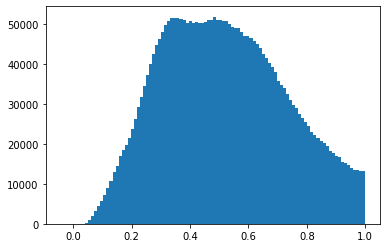

In [14]:
plt.figure()
plt.hist(cosine_sim.flatten(), bins = 100)
plt.show()

In [15]:
train_df.head(1)

,user_id,business_id,stars,review_id,text
0,--2HUmLkcNHZp0xw6AMBPg,yX0pOWG_Be9TjGnm0aihVA,5.0,tfi5EOpqZw637p3AJtOUMg,Obsessed with their chicken salad and sweet fr...


In [41]:
def get_recommendation_cos(reviews, business_id, user_id, df_sim, k):
    '''get the business_id_array that shows top_k greatest similarity to the specific business_id'''
    user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
    df_user = df_sim.loc[df_sim.index.isin(user_bids), df_sim.columns == business_id]
    df_user_topk = df_user.sort_values(df_user.columns[0], ascending = False).iloc[:k]
    
    return np.array(df_user_topk.index.values)


def predict_rating(reviews, user_id, business_ids):
    '''predict the avg of the user's rating on business in business_ids'''
    scores = reviews.loc[(reviews.user_id == user_id) & (reviews.business_id.isin(business_ids))]["stars"].values
    
    return np.mean(scores)


def get_results_cos(reviews, reviews_test, business_id, user_id, df_sim, k):
    '''
    prediction on the business_id：avg the ratings on top_k business that shows similarity to the business_id
    actual on the business_id: the true rating 
    '''
    actual = reviews_test.loc[(reviews_test.user_id==user_id) & (reviews_test.business_id==business_id)]['stars'].values[0]
    business_ids = get_recommendation_cos(reviews, business_id, user_id, df_sim, k)
    prediction = predict_rating(reviews, user_id, business_ids)
    
    return actual, prediction

def get_review_processed(processed, reviews):
    reviews_processed = reviews.loc[reviews.business_id.isin(processed.business_id)]\
                                                       .reset_index()\
                                                       .drop(columns=['index'])
    return reviews_processed

In [42]:
reviews_processed = get_review_processed(df_texts_train, train_df)
reviews_processed.head()

,user_id,business_id,stars,review_id,text
0,--2HUmLkcNHZp0xw6AMBPg,yX0pOWG_Be9TjGnm0aihVA,5.0,tfi5EOpqZw637p3AJtOUMg,Obsessed with their chicken salad and sweet fr...
1,--2HUmLkcNHZp0xw6AMBPg,u9R0_pvEkl7QGPJYH3j1sg,5.0,_FcKYC5R81v6SbSeaWxHNA,This place is INCREDIBLE. We just bought a ho...
2,--2HUmLkcNHZp0xw6AMBPg,cHdJXLlKNWixBXpDwEGb_A,5.0,wK3roBOGrakzjoX_o5nmBw,Pretty decent for something a little different...
3,--2HUmLkcNHZp0xw6AMBPg,LR_99E7tVUfxqemvcGkDzw,3.0,_d9cfYYjzuJwhLe5egMLIQ,This place has pretty decent food but their se...
4,--2HUmLkcNHZp0xw6AMBPg,lfyg98UFNYMVk18p6LIlkw,5.0,_yreTg27A_fsPb8uulhKtg,"Love this place. Amazing food, great selectio..."


In [18]:
def CB_NLP_predict(reviews, reviews_test, df_sim, k = 5):
    '''
    based on test_df 
    get a dataframe with each user on each business's true ratings and prediction ratings
    @k: int, top k similar businesses
    '''
    user_id_sample = reviews_test['user_id'].values
    busi_id_sample = reviews_test['business_id'].values
    
    actual = []
    predictions = []
    
    for i in range(len(reviews_test)):
        try:
            act, pred = get_results_cos(reviews, reviews_test, busi_id_sample[i], user_id_sample[i], df_sim, k)
            actual.append(act)
            predictions.append(pred)
            
        except:
            actual.append(np.nan)
            predictions.append(np.nan)
            
    return pd.DataFrame({"user_id": user_id_sample,
                         "business_id": busi_id_sample,
                         "true_ratings": actual,
                         "prediction_ratings":  predictions                        
                        })

### - Tuning parameters k

In [19]:
valid_df.head(3)

,user_id,business_id,stars,review_id,text
0,--2HUmLkcNHZp0xw6AMBPg,lRL7x-HMBscWyELxEVq85w,5.0,QoXopP3TkAFmhT9-N07umQ,I really enjoyed this place they have a really...
1,--4rAAfZnEIAKJE80aIiYg,ElWzx5_fU8S2G45OnM-HpA,2.0,aUP_1NZa4dn9oLQUZerNfQ,Not impressed at all. We came for dinner on a ...
2,--CIuK7sUpaNzalLAlHJKA,j-3kj1ZCKINyqRVHbWHv3Q,5.0,4NTe_Ivl_T-bclmWVLWNew,"So look, I'm simple when it comes to BBQ. I do..."


In [20]:
t0 = time.time()
df_pred_results = pd.DataFrame(columns= ["ks", "sample_size", "rmse", "mae"])
sample_sizes = [len(valid_df)]
ks = [5,15,25,35]

for sample_size in sample_sizes:
    for k in ks:
        valid = CB_NLP_predict(train_df, valid_df.sample(n = sample_size, random_state = 12), df_sim, k)
        rmse = mean_squared_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)**0.5
        mae = mean_absolute_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)**0.5
        df_pred_results = df_pred_results.append({"ks": k, "sample_size": sample_size,
                                                  "rmse": rmse, "mae": mae}, ignore_index = True)
t1 = time.time()
print("time elapsed: (seconds)")
print(np.round(t1 - t0,3))

time elapsed: (seconds)
2527.366


optimal k (nearest neighbors):
3    35.0
Name: ks, dtype: float64


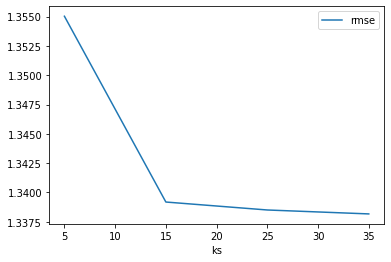

In [21]:
df_pred_results[df_pred_results["sample_size"] == sample_size].plot("ks", "rmse")
print("optimal k (nearest neighbors):")
print(df_pred_results.loc[df_pred_results["rmse"] == np.min(df_pred_results.rmse) ,"ks"])

In [23]:
df_pred_results.to_csv("Content_Based_Filtering_Cosine_Evaluation.csv",index = False)

## LSI Model

### - 2 parameters to tune: n topics and k nearest businesses

In [ ]:
def get_lsi(processed, reviews, user_id, n_topics):
    '''
    get the lsi model for user_id
    '''
    user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
    processed_user = processed.loc[processed.business_id.isin(user_bids)]
    documents = list(processed_user['text'].values)
    texts = [[word for word in document.split(' ')] for document in documents]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts] 

    lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=n_topics)
    
    return lsi, dictionary, corpus

In [ ]:
#### Dont run this cell !!!

df_lsi = pd.DataFrame(columns = ["user_id","n_topic", "lsi", "dictionary"])
n_topics = [10,20,50,80,100,150]

for n_topic in n_topics:
    for i in range(len(test_df)):
        lsi, dictionary, corpus = get_lsi(df_texts_train, train_df, user_id_sample[i], n_topic)
        df_lsi = df_lsi.append({"user_id": test_df.user_id[i],
                                "n_topic": n_topic,
                                "lsi": lsi,
                                "dictionary": dictionary}, ignore_index = True)

In [ ]:
def get_recommendation_lsi(processed, reviews, df_lsi, business_id, user_id, k, n_topics):
    lsi = df_lsi[(df_lsi["n_topic"] == n_topics) & (df_lsi["user_id"] == user_id)]["lsi"][0]
    dictionary = df_lsi[(df_lsi["n_topic"] == n_topics) & (df_lsi["user_id"] == user_id)]["dictionary"][0]
    user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
    processed_user = processed.loc[processed.business_id.isin(user_bids)]
    documents = list(processed_user['text'].values)
    texts = [[word for word in document.split(' ')] for document in documents]
    corpus = [dictionary.doc2bow(text) for text in texts] 
    
    doc = processed['text'].loc[processed.business_id==business_id].values[0]
    vec_bow = dictionary.doc2bow(doc.lower().split())
    vec_lsi = lsi[vec_bow]
    index = similarities.MatrixSimilarity(lsi[corpus])
    sims = list(index[vec_lsi])
    results = list(zip(user_bids, sims))
    results_ordered = np.array(sorted(results, key=lambda x: x[1], reverse=True))
    results_topk = results_ordered[:k]
    
    return results_topk[:,0]

def get_results_lsi(processed,reviews,reviews_test, df_lsi ,business_id,user_id,k,n_topics):
    actual = reviews_test.loc[(reviews_test.user_id==user_id) & (reviews_test.business_id==business_id)]['stars'].values[0]
    business_ids = get_recommendation_lsi(processed,reviews,df_lsi ,business_id,user_id,k,n_topics)
    prediction = predict_rating(reviews, user_id, business_ids)
    
    return actual, prediction

In [ ]:
def get_recommendation_lsi(processed,reviews,business_id,user_id,k,n_topics):
    user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
    processed_user = processed.loc[processed.business_id.isin(user_bids)]
    documents = list(processed_user['text'].values)
    texts = [[word for word in document.split(' ')] for document in documents]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts] 

    lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=n_topics)
    doc = processed['text'].loc[processed.business_id==business_id].values[0]
    vec_bow = dictionary.doc2bow(doc.lower().split())
    vec_lsi = lsi[vec_bow]
    index = similarities.MatrixSimilarity(lsi[corpus])
    sims = list(index[vec_lsi])
    results = list(zip(user_bids, sims))
    results_ordered = np.array(sorted(results, key=lambda x: x[1], reverse=True))
    results_topk = results_ordered[:k]
    
    return results_topk[:,0]

def get_results_lsi(processed,reviews,reviews_test ,business_id,user_id,k,n_topics):
    actual = reviews_test.loc[(reviews_test.user_id==user_id) & (reviews_test.business_id==business_id)]['stars'].values[0]
    business_ids = get_recommendation_lsi(processed,reviews,business_id,user_id,k,n_topics)
    prediction = predict_rating(reviews, user_id, business_ids)
    
    return actual, prediction

In [ ]:
def CB_LSI_predict(df_texts_train, reviews, reviews_test, k = 5, n_topics = 100):
    uid_sample = reviews_test['user_id'].values
    bid_sample = reviews_test['business_id'].values
    actual_lsi = []
    predictions_lsi = []
    for i in range(len(reviews_test)):
        try:
            act, pred = get_results_lsi(df_texts_train, reviews, reviews_test, bid_sample[i],uid_sample[i], k, n_topics)
            predictions_lsi.append(pred)
            actual_lsi.append(act)

        except:
            predictions_lsi.append(np.nan)
            actual_lsi.append(np.nan)
            
    return pd.DataFrame({"user_id": uid_sample,
                         "business_id": bid_sample,
                         "ratings": actual_lsi,
                         "pred_lsi":  predictions_lsi                       
                        })

In [ ]:
t0 = time.time()
df_pred_results_lsi = pd.DataFrame(columns= ["ks","n_topics","sample_size", "rmse", "mae"])
# sample_sizes = [100]
ks = [40]
n_topics = [20,50,80,100]

# for sample_size in sample_sizes:
for k in ks:
    for n_topic in n_topics:
        test = CB_LSI_predict(df_texts_train,train_df, test_df, k = k, n_topics = n_topic)
        rmse = mean_squared_error(test.dropna().pred_lsi, test.dropna().ratings)**0.5
        mae = mean_absolute_error(test.dropna().pred_lsi, test.dropna().ratings)**0.5
        df_pred_results_lsi = df_pred_results_lsi.append({"ks": k, "n_topics": n_topic,"sample_size": len(test_df),
                                "rmse": rmse, "mae": mae}, ignore_index = True)
t1=  time.time()
print("time elapsed: (seconds)")
print(np.round(t1- t0,3))

In [58]:
df_pred_results_lsi

,ks,n_topics,sample_size,rmse,mae
0,40.0,20.0,20433.0,1.165239,0.914670
1,40.0,50.0,20433.0,1.165827,0.915209
2,40.0,80.0,20433.0,1.166328,0.915811
3,40.0,100.0,20433.0,1.166328,0.915811


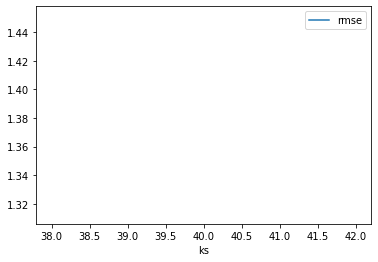

In [90]:
df_pred_results_lsi[df_pred_results_lsi["n_topics"] == 120].plot("ks", "rmse")

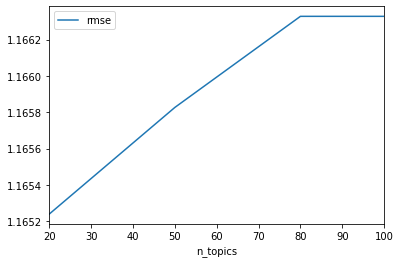

In [59]:
df_pred_results_lsi[df_pred_results_lsi["ks"] == 40].plot("n_topics", "rmse")

In [349]:
mean_squared_error(test.dropna().pred_lsi, test.dropna().ratings)**0.5

0.0

In [333]:
df_pred_results_lsi

,ks,n_topics,sample_size,rmse,mae
0,10.0,10.0,50.0,0.0,0.0
1,10.0,50.0,50.0,0.0,0.0
2,10.0,100.0,50.0,0.0,0.0
3,10.0,200.0,50.0,0.0,0.0


In [34]:
%timeit get_results_lsi(df_texts_train, train_df, test_df, bid_sample[0], uid_sample[0], 30,10)

651 ms ± 37.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
# experiement
uid_sample = test_df['user_id'].values
bid_sample = test_df['business_id'].values
act, pred = get_results_lsi(df_texts_train, train_df, 
                                test_df, 
                                bid_sample[0], 
                                uid_sample[0], 
                                30,
                                20)

In [54]:
act, pred

(5.0, 4.633333333333334)

# Mixture Model

- Add additional similarity matrix on top of the cosine similarity matrix

- Extracte additional information for the business dataset

- Compute the similarity between different businesses based on the numerical variables available in the business dataset. For example, stars, review_count etc.

- The new matrix is a linear combination of the cosine similarity matrix and the additional matrix, with both matrices multiplied by a factor $\lambda$ and $1-\lambda$

- The next step would be finding out the optimal value of $\lambda$, which is defaulted as 0.5

In [31]:
business = pd.read_csv('../data/business_data_subset.csv')

In [32]:
business_sub = business[['business_id', 'latitude', 'longitude', 'stars', 'review_count', 'is_open']]
business_sub.head(3)

,business_id,latitude,longitude,stars,review_count,is_open
0,CsLQLiRoafpJPJSkNX2h5Q,35.194894,-80.767442,3.0,5,0
1,vjTVxnsQEZ34XjYNS-XUpA,33.602822,-111.983533,4.0,10,1
2,fnZrZlqW1Z8iWgTVDfv_MA,36.099738,-115.301568,2.5,15,0


In [37]:
def get_mix_sim_matrix(processed, lmbda, business):
    tfidf_matrix = get_tfidf_matrix(processed)
    cosine_sim = get_cos_sim_matrix(tfidf_matrix, 20)
    business_sub = business[['business_id', 'latitude', 'longitude', 'stars', 'review_count', 'is_open']]
    business_processed = business_sub[business_sub['business_id'].isin(processed['business_id'])]\
                                                                 .set_index('business_id')
    scaler = StandardScaler()
    X = scaler.fit_transform(business_processed)
    eucl_dis = euclidean_distances(X,X)
    eucl_sim = 1/np.exp(eucl_dis)
    mixed_sim = np.add(cosine_sim*lmbda,eucl_sim*(1-lmbda)) # assume equally weighted

    return mixed_sim

### - Set $\lambda$ = 0.5

In [38]:
mixed_sim = get_mix_sim_matrix(text_train_df, 0.5, business)
mixed_sim.shape

(1728, 1728)

In [ ]:
predictions_mix = []
actual_mix = []
for i in range(len(reviews_processed)):
    try:
        act, pred = get_results_cos(df_texts_train, 
                                    reviews_processed, 
                                    business, 
                                    busi_id_sample[i], 
                                    user_id_sample[i], 
                                    mixed_sim, 
                                    5)
        predictions_mix.append(pred)
        actual_mix.append(act)
    
    except:
    next

In [ ]:
rmse_mix = mean_squared_error(predictions_mix, actual_mix)**0.5
mae_mix = mean_absolute_error(predictions_mix, actual_mix)
print(f'RMSE: {rmse_mix}, MAE: {mae_mix}')

In [ ]:
cov_mix = get_coverage(processed,reviews,business,mixed_sim,5)
print(f'coverage: {cov_mix}')

### - Tune $\lambda$ 

In [ ]:
def tuning_mix_param(lmbdas,
                     processed, 
                     reviews, 
                     business):
    rmse_mix = []
    reviews_processed = get_review_processed(processed, reviews)
    user_id_sample = reviews_processed['user_id'].values
    busi_id_sample = reviews_processed['business_id'].values

    for lmbda in lmbdas:
        mixed_sim = get_mix_sim_matrix(processed, lmbda, business)
        predictions_mix, actual_mix = [], []
        for i in range(len(reviews_processed)):
            try:
            act, pred = get_results_cos(processed, 
                                        reviews_processed, 
                                        business, 
                                        bid_sample[i], 
                                        uid_sample[i], 
                                        mixed_sim, 
                                        5)
            predictions_mix.append(pred)
            actual_mix.append(act)
            except:
            next
            
        rmse = mean_squared_error(predictions_mix, actual_mix)**0.5
        rmse_mix.append(rmse)
  
  return rmse_mix

In [ ]:
processed_s = get_processed(text_train_df)
lmbdas = np.linspace(0,1,5)
rmse_mix_tune = tuning_mix_param(lmbdas,
                                 processed_s, 
                                 reviews, 
                                 business)
rmse_mix_min = min(rmse_mix_tune)
rmse_mix_min_idx = rmse_mix_tune.index(rmse_mix_min)
lmbda_min = lmbdas[rmse_mix_min_idx]

In [ ]:
plt.plot(lmbdas, rmse_mix_tune)
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.title('RMSE for different mixture models')
plt.plot([lmbda_min], [rmse_mix_min], 'o')
plt.show()